# Basics of Mobile Robotic : Project

__Group members :__ <br>
- Khalil Haroun Achache (300350) <br>
- Barbara Joanne De Groot (296815) <br>
- Killian Hinard (312106) <br>
- Louis Francois Robert Von Wattenwyl (302808)

## Introduction to our environment :

Oh no ! A fire has started in the middle of the city... Luckily SuperThymio is there to save the day ! As soon as the fire is located, SuperThymio takes the shortest path to reach it and arrives in no time to end the fire. The city is saved...once more... by SuperThymio.

In our project, the city is modelized by a white floor with 3d black obstacles. The white floor eases the job of the computer vision (CV) as patterns are easily recognizable with a white background. We decided to have 3D obstacles so that they could still be recognized by the local avoidance and ensures that even if a new obstacle appears near a permanent obstacle, the robot will also avoid the permanent obstacle.\
SuperThymio is equipped with a blue sign on its top, a triangle and a circle. This enables us to use pattern recognition to find the position as well as orientation of the robot. \
The fire is modelized by a red cube. \
All the different components of environment have been chosen to have high contrast between each other to ease the job of the computer vision. Alongside the live video feedback we also added a clean visualization where SuperThymio is represented by a firetruck and the target is reprensented by a fire to help the imagination.

To have a stable environment, especially regarding the lighting condition, we set the environment in the studio of one of the team members. This way, we had a room where we could run our project without worrying about the outside light or other disturbances.

See below an anotated image of our environment.

![Pentagon](image_rapport/environment.png)

## Modules of the firefighter project 

The Firefighter project has five different modules : 
- Computer Vision (CV)
- Global Navigation (GN)
- Kalman Filter (KF)
- Motion Control (MC)
- Local Avoidance (LA)

The CV runs on a separate thread to enable regular update of the robot's position.

## How the different modules interact with each other

__Initialization__ 

1. Start the CV thread
2. Connect to Thymio
3. CV computes the robots and targets coordinates as well as the enlarged obstacles coordinates
4. The GN computes the shortest path from the robots location to the target
5. Initialization of the KF

__Computer Vision Thread__

Updates the robots position using CV. 

__Main loop__

This loop works as follows :

![Pentagon](image_rapport/main_loop_dg_trans.png)

The LA module directly uses the MC module.

You'll find below details about every module.

In [ ]:
import LocalNavigation as ln
import MotionControl as mc
import GlobalNavigation as gn
import ComputerVision as cv
import KalmanFilter as kf
import math

## Computer Vision

The computer vision module is in charge of performing 4 tasks: identify the area, the obstacles, the target and the robot's position.
To this end, the module contains 4 main methods:

For the demo, we first load the image we will be using for our tests

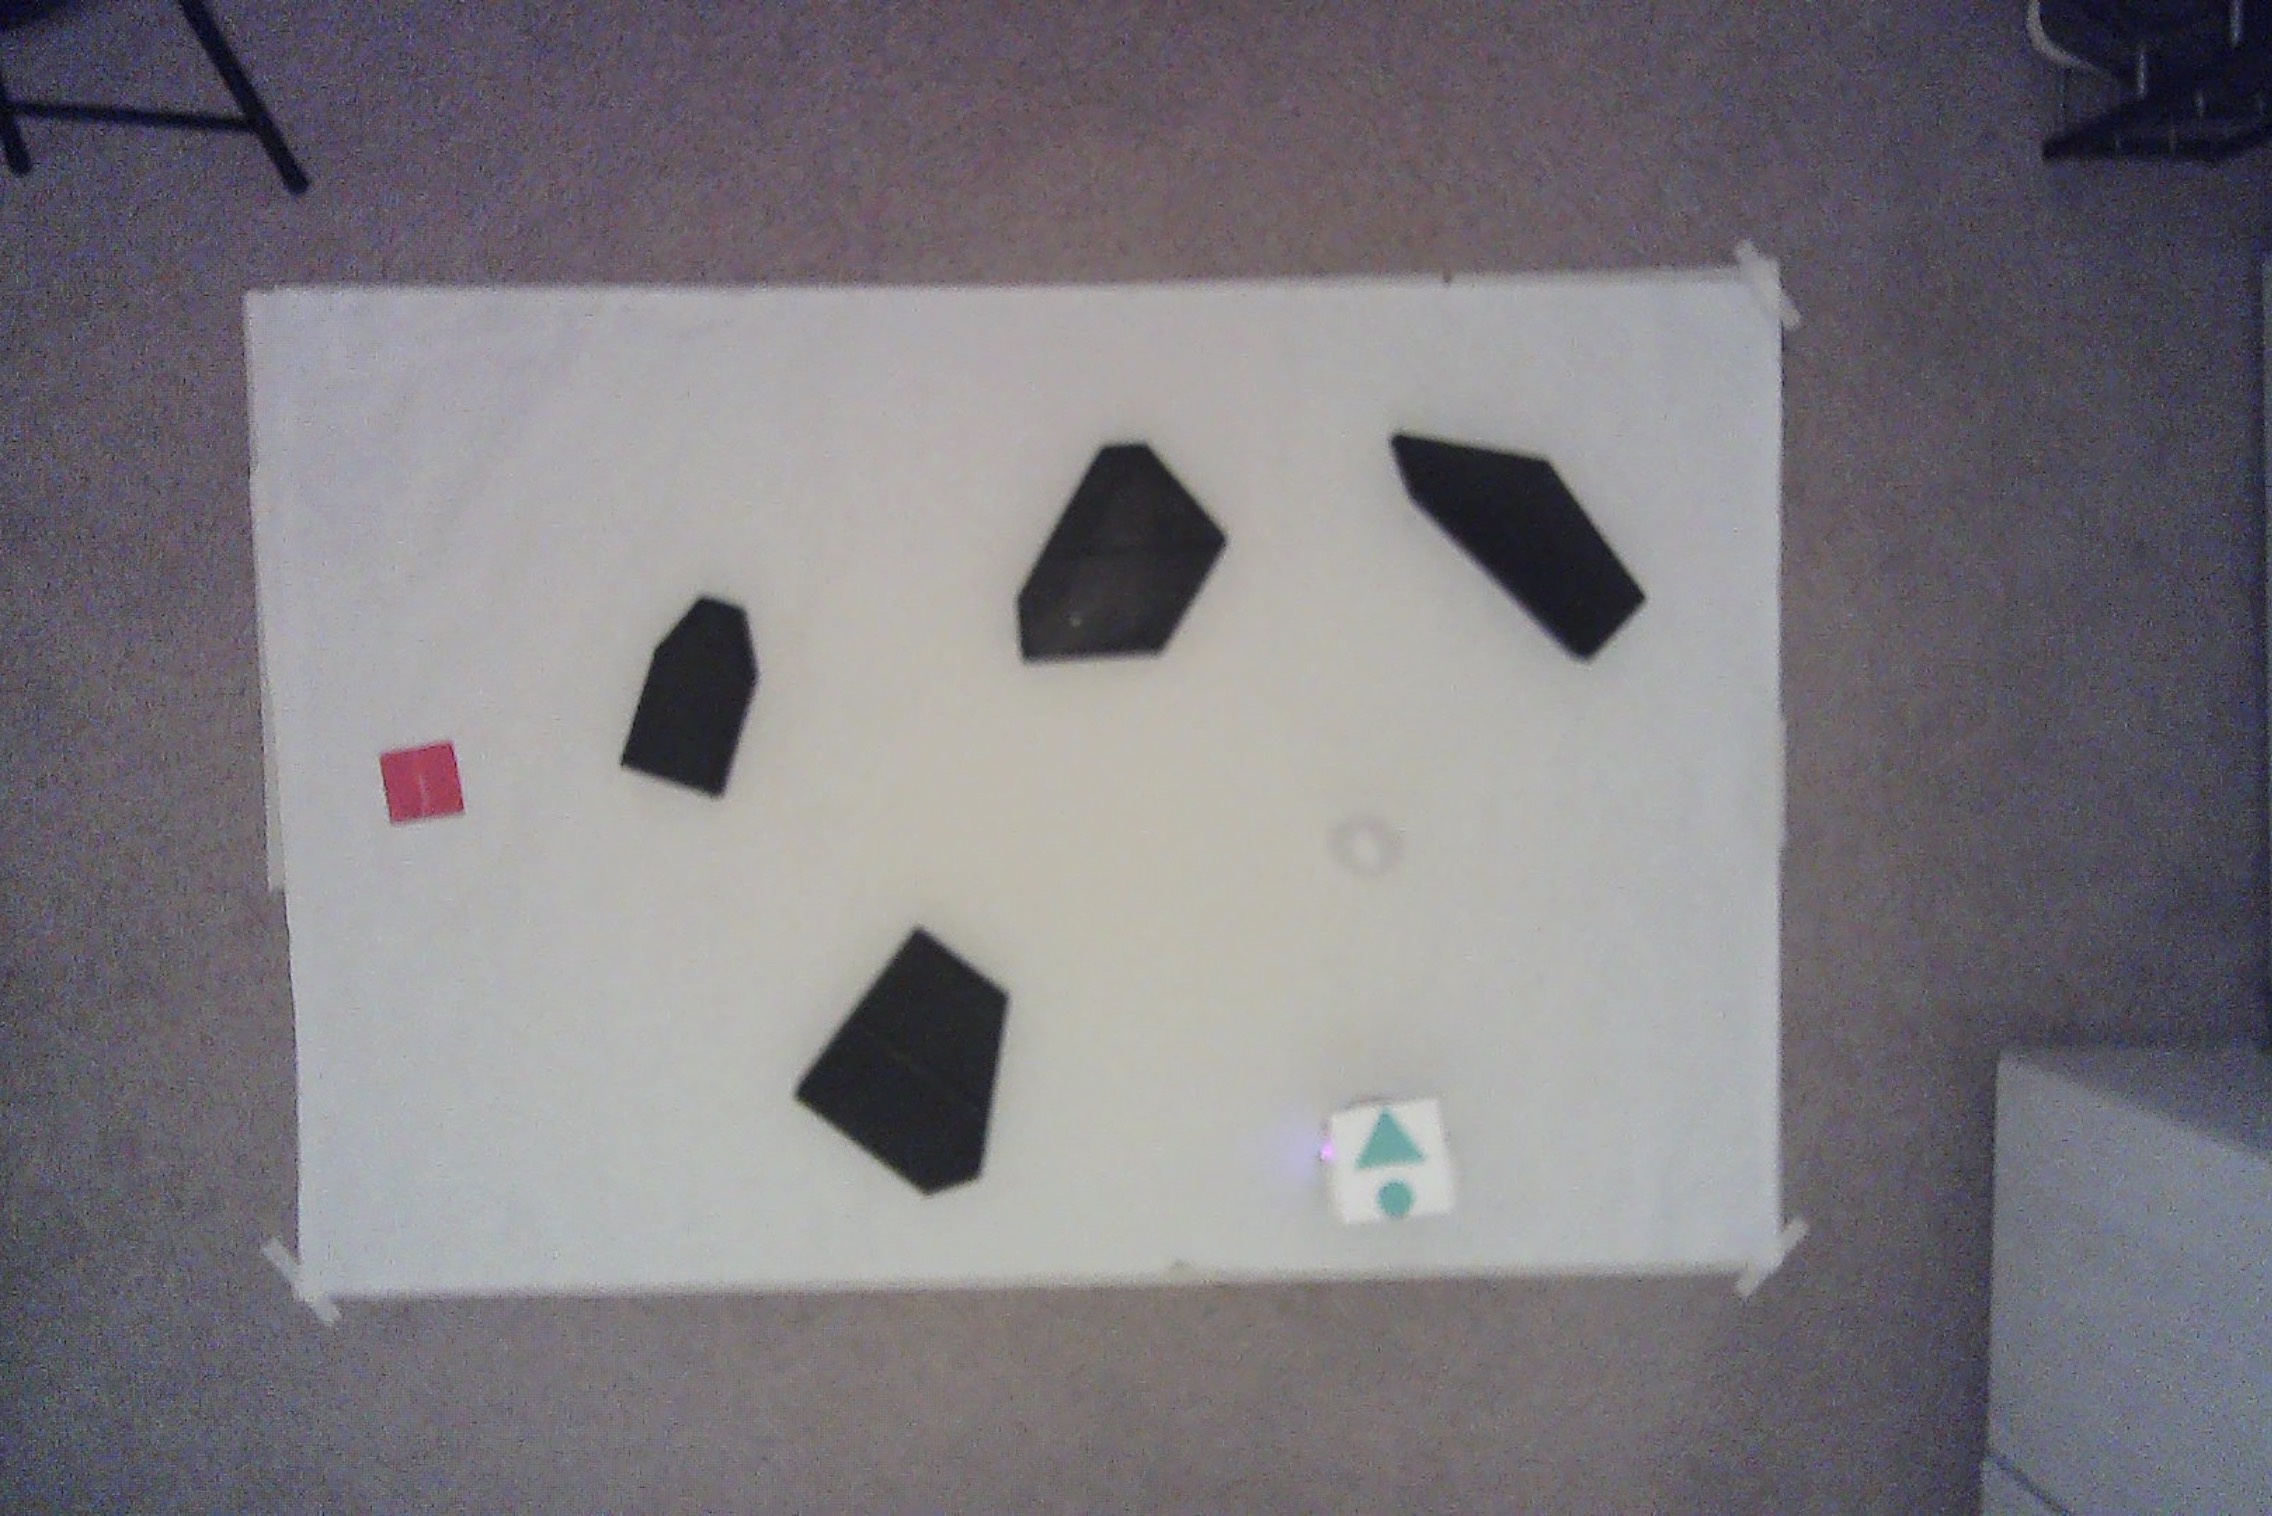

In [1]:
import ComputerVision as cv
import helpers
import cv2

image = cv2.imread("image_rapport/demo_image.jpg")
helpers.display_image_in_notebook(image)

### The get_area method:

This method crops the image with the given crop paramters corresponding to the center, width, height and angle of the rectangle representing the play area.
If these parameters are not given, the method calls the find_area method to retrieve these parameters.
The retrieved parameters will allow us to have a fixed reference for the future images taken by the webcam.

Retrieved crop parameters (1021, 789, 1014, 1527, 89.0614242553711)


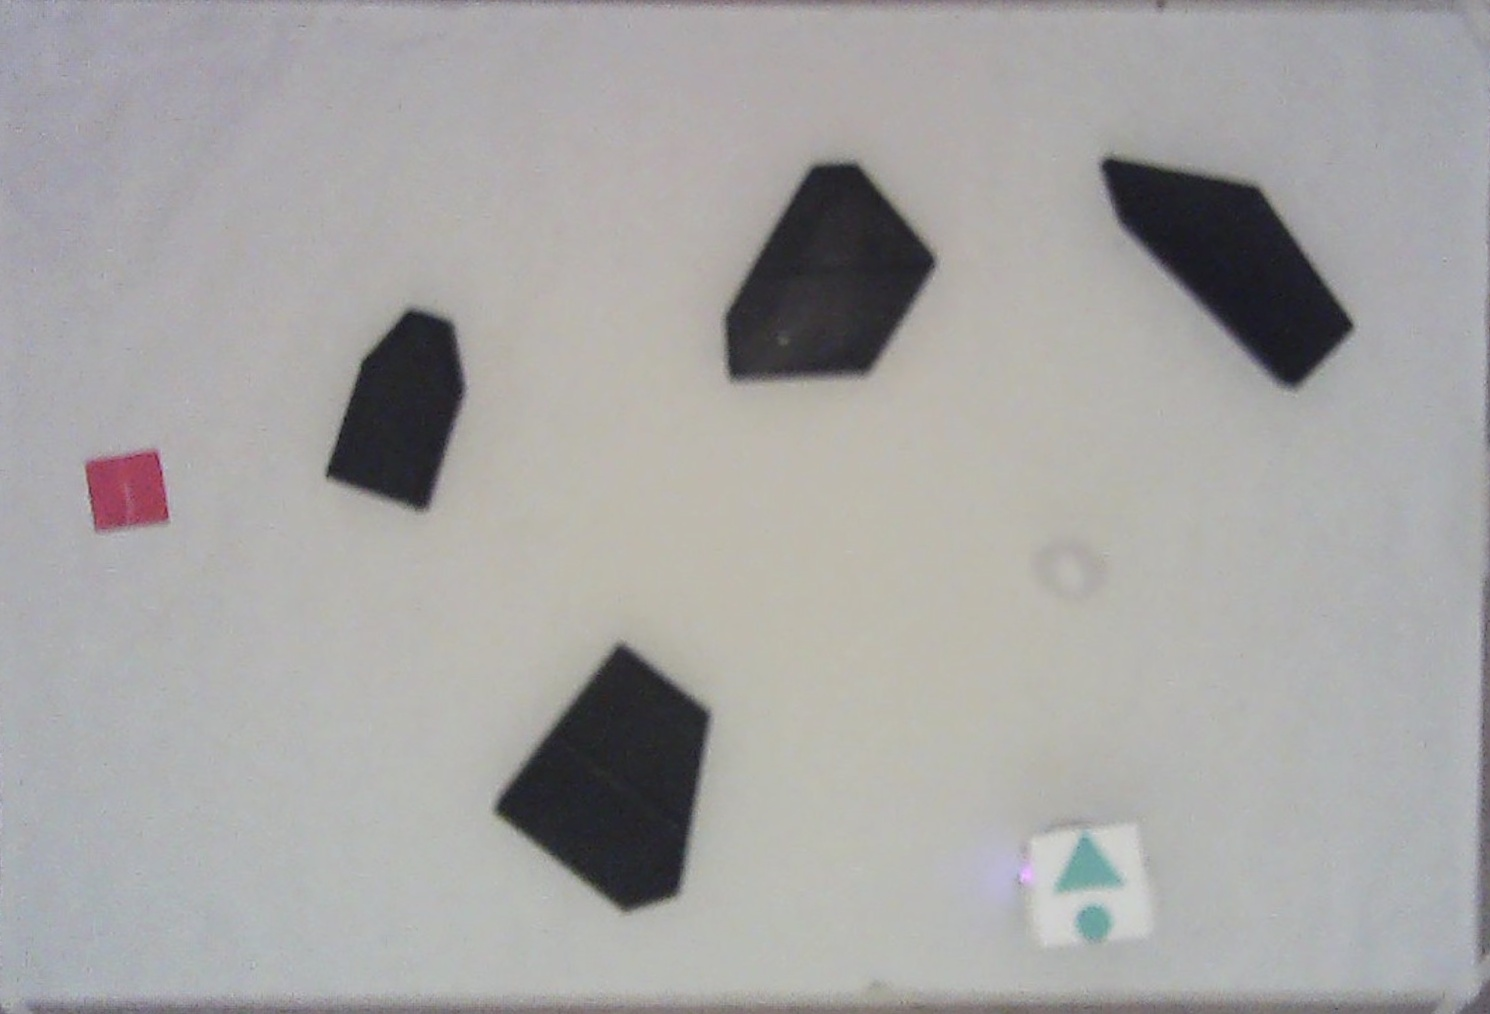

In [2]:
cropped_image, crop_params= cv.get_area(image)
print("Retrieved crop parameters",crop_params)
helpers.display_image_in_notebook(cropped_image)


Internally,the find_area  works by performing threholding on the image as to filter out the white area of the image. 

Once we have the black and white image, we find the contours on that image and then we approximate the contours and filter out on the ones that have a small area (to remove noise)

For each remaining contour, we retrieve the minimum area rectangle and save the position, width, height and angle of rotation. 
Finally, we return the rectangle with the highest surface area

### The find_obstacles method

the find obstacles method retrieves the coordinates of the corners of the obstacle elements of the map; with a margin to allow the thymio to move in.
it gets as an input the (cropped) image of the area and returns a list of these corners

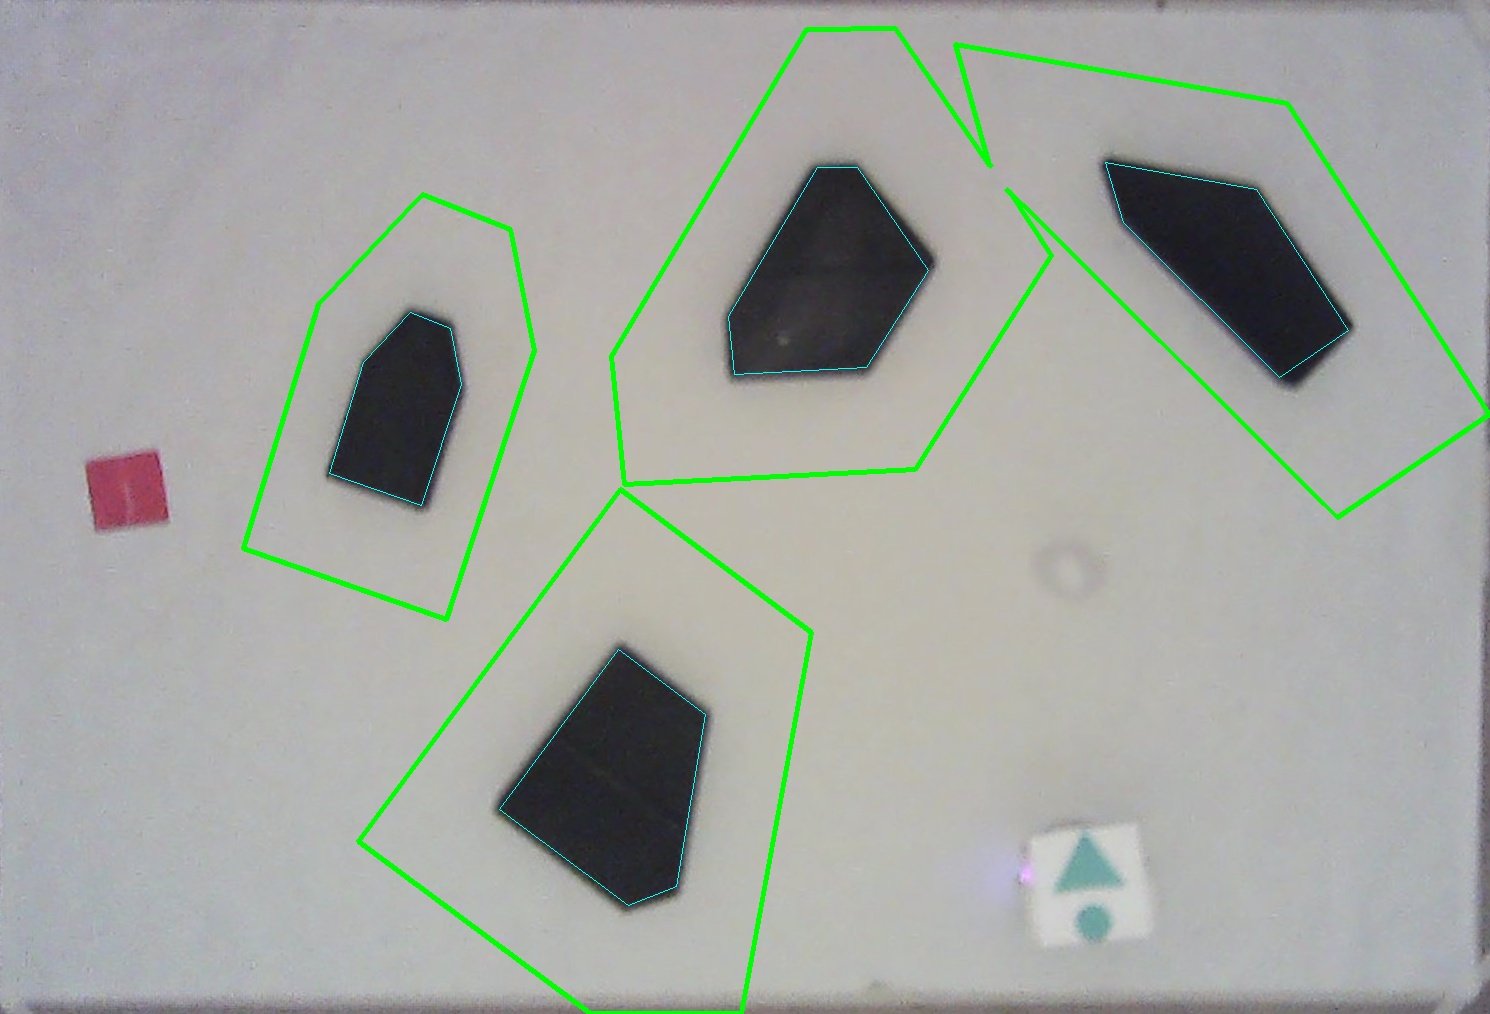

In [3]:
obstacles_image = cropped_image.copy()
obstacles = cv.find_obstacles(obstacles_image,overlay=True)
helpers.display_image_in_notebook(obstacles_image)

Internally, in the method, 
we:
1. threshold the image to only have white pixels representing the obstacles and black as the background.
2. find the contours on that thresholded image
3. approximate them into polygons
4. filter out the noise by removing the polygons with small area


As we are using a visibility graph in the global path plannning, we have to allow a margin between the nodes of the graph (edges of obstacles) and the real edges of the obstacles. 

To do that, we:


5. scale the polygons with the scale_contours method (in helpers.py), which finds the center of each polygon and offsets the corners along the axis made by the center of the polygon the corresponding corner.


As we might get an overlap of some contours (this overlap means that our little Thymio might not be able to pass between these obstacles), we need to combine these contours.

For that , we:


6. create an empty image and draw on it the scaled polygons
7. retrieve the final contours. 
This method allows us to merge obstacles that are too close to each other for our little Thymio.

### The find_target_method

the find_target method finds the target of the thymio, which in our case corresponds to a red square in the image.
It takes as input the (cropped) image of the area and returns the coordinates of the obstacle

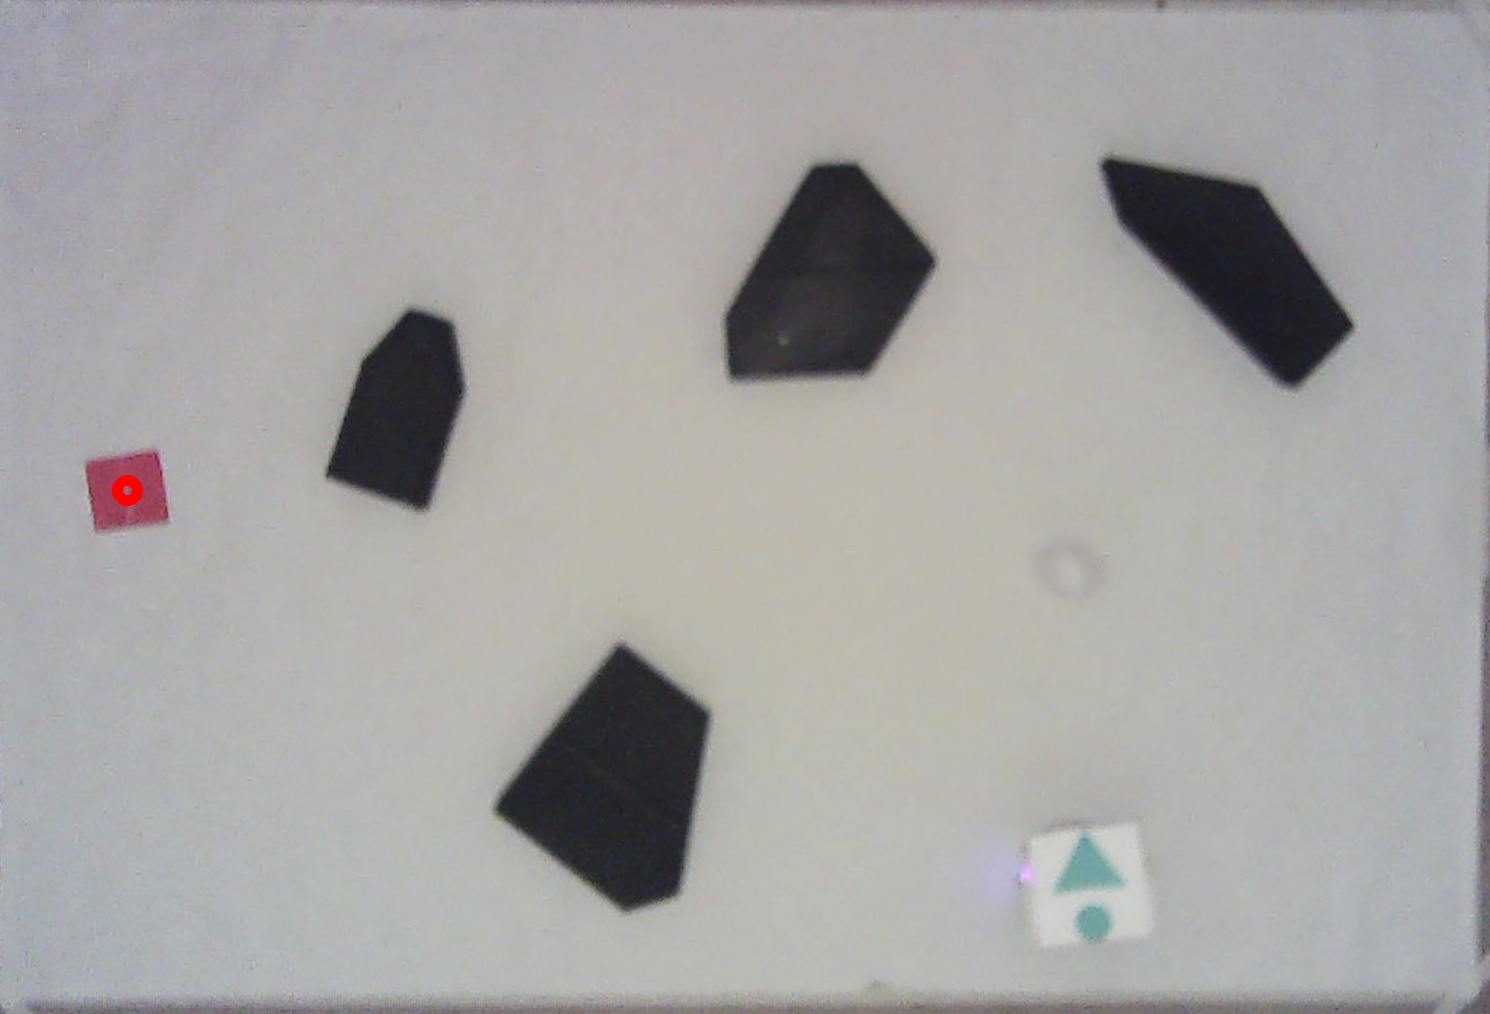

In [4]:
target_image = cropped_image.copy()
target = cv.find_target(target_image,overlay=True)
helpers.display_image_in_notebook(target_image)

Internally, to retreive the target, we:

1. perform thresholding on a range of HSV values. 


Here, we used three different HSV values to filter on and combined them with a bitwise or, as due to reflections and the position in which the target is placed,
the thresholding HSV values change.

After that, we:

2. find the approximated contours of the image
3. sort them by descending surface area
4. take the largest contour as our target's contour.
5. find the minimum enclosing circle on that contour to retrieve the center of our obstacle.

### The get_robot method:

the find_robot method retrieves the coordinates of the robot in the image as well as its orientation. 
It takes as input the (cropped) image of the area and returns the coordinates and angle of the robot if we found it, otherwise a null object

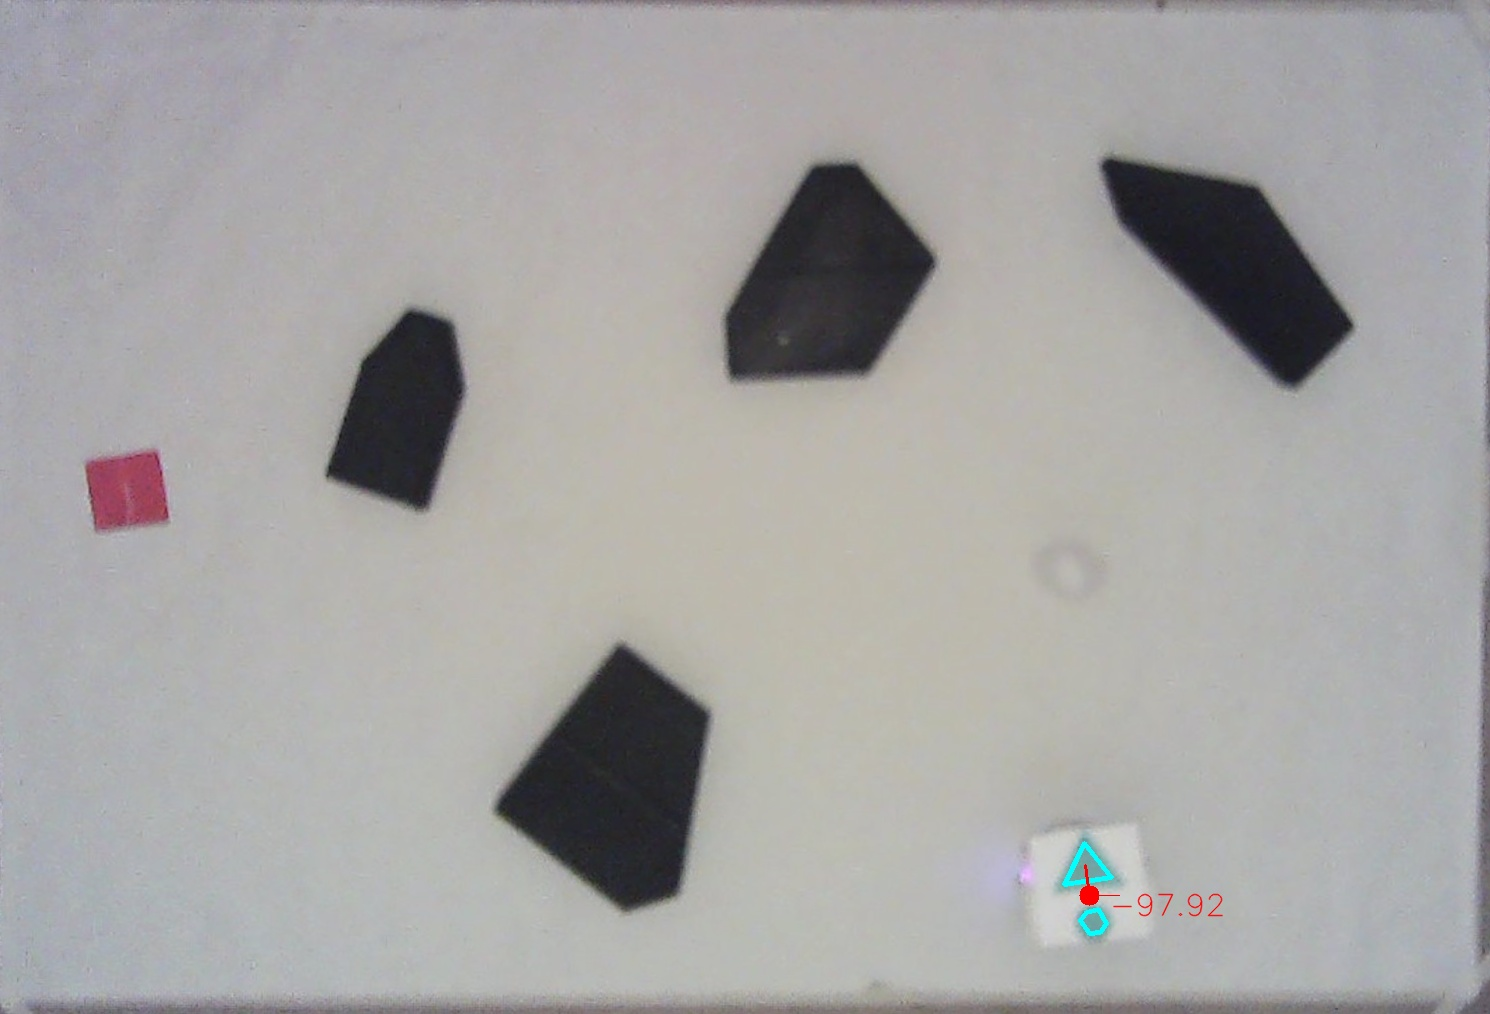

In [5]:
robot_image = cropped_image.copy()
robot_pos,robot_angle = cv.find_robot(robot_image,overlay=True)
helpers.display_image_in_notebook(robot_image)

Internally, the method is similar to the find_target method, but has another challenge which is to find the orientation of the robot. 


To this end, we used a pattern on the Thymio that will allow us to more easliy find it. there is a triangle and a circle with different surfaces.

We:
1. perform filtering on the colors similar to the one in the find target but rather on the cyan color
2. retrieve the contours on that image, approximate them and filter the ones with a small area
3. save the two smallest polygons with lowest surface area


Here, the smallest one would be the circle and the larger one the triangle.


Once we have the coordinates of these two elements, the robot's coordinates will be the mean of the coordinates of these two polygons and the orientation is the angle of the vector created by these two points and the (0,1) vector.

If there's any problem within the procedure, we simply return a None object

## Global Navigation

 The goal of the GN is to compute the shortest path between the initial position of the robot (start point) and the target. It takes as inputs the coordinates of the enlarged obstacles corners, of the robot and of the target. It will output the list of points through which the robot has to go to reach the target. 

We chose the visibility graph method, detailed below, as it is the algorithm that gives you the shortest path for this kind of environment. The obstacles were enlarged with the computer vision because it was much easier to implement it this way. Thus we can directly feed the input obstacles corners coordinates to the algorithm without preprocessing them.

#### 1. Connecting all the points that can see each other
First we use the NetworkX librairy to create a node graph from all the inputs : the coordinates of the enlarged obstacles corners, the start and target coordinates.

To do this we need a function to check if two segments intersect. We used a method based on the orientation of the segments detailed here https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

We begin by connecting the starting point to all the points it can see. For each point x of the graph, we check if the segment start-x intersects with any of the obstacles' sides. If not, we connect them together. \
Then, we connect the corners of the same obstacle together without connecting the diagonals together. We take care to delete segments that are on the edge of the map as shouldn't be part of the path. \
After, we connect the obstacles corners of different obstacles that can see each other. For each corner x, we check if it can see a corner y  by checking any intersection between x-y and the sides of all obstacles. \
Finally, we connect the target to all the points it can see. For each point x of the graph, we check if the segment target-x intersects with any of the obstacles' sides. If not, we connect them together.

When connecting two points, a weight corresponding to the distance between the points is added to the edge.

#### 2. Search the shortest path from start to target

The NetworkX librairy already has a method to compute the shortest path between two points of a node graph, taking in account the distance thanks to the weights assigned to each edge. It uses the Dijkstra's algorithm to find the shortest road from start to target.

#### Results
Let's see the resulting node diagram and the path found by the algorithm :

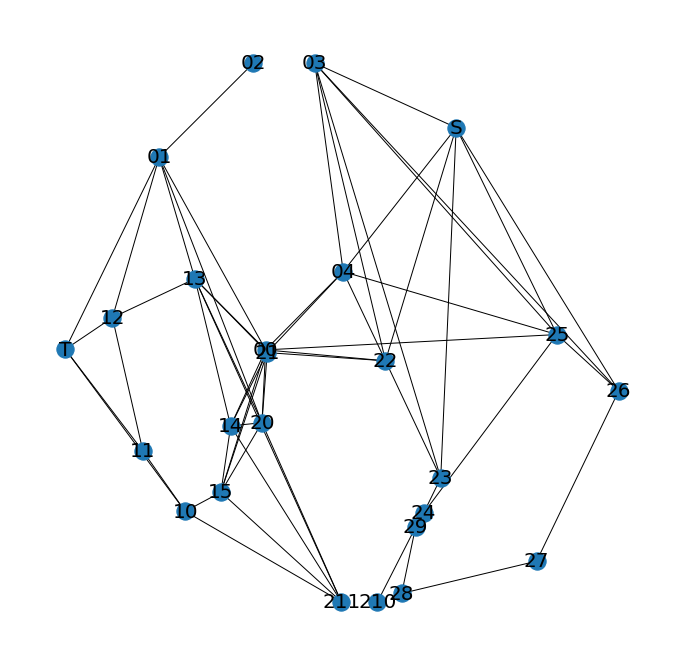

['S', '04', '00', '13', '12', 'T']


In [46]:
path=gn.find_path(
        robot_pos,
        obstacles_scaled,
        target,
        (crop_params[2], crop_params[3]),
        display_graph=True,
    )

As an example for checking the intersections, we can see the result of the intersection checking function for segments 03-22 and S(=robot's position)-04, which intersect :

In [48]:
obstacles=gn.formatting_data(obstacles_scaled) #first we need to format the output of the CV

In [49]:
intersect=gn.doIntersect(obstacles[0][3][0],obstacles[0][3][1],
              obstacles[2][2][0],obstacles[2][2][1],
              robot_pos[0],robot_pos[1],
              obstacles[0][4][0],obstacles[0][4][1])
print(intersect)

True


Then for segments 03-22 and S-25 which do not intersect :

In [50]:
intersect=gn.doIntersect(obstacles[0][3][0],obstacles[0][3][1],
              obstacles[2][2][0],obstacles[2][2][1],
              robot_pos[0],robot_pos[1],
              obstacles[2][5][0],obstacles[2][5][1])
print(intersect)

False


## Kalman Filter 

The goal of this module is to integrate the mesurements (the position, the angle) with the information from the motor to estimate a reasonable state for the Thymio.
For the state estimation of our Thymio we use the Kalman filter. It's a recursive estimator where only the estimated state from the previous time step and the current measurement are needed to compute the estimate for the current state. The filter is inspired from the sesion exercice.

The Kalman filter takes the following form:

The first step is to make a prediction of the state and an a-priori variance estimate P . The state vector contain the position of the thymio, the angle rotation, the speed and the angular speed.

$$ E^{t} = \begin{pmatrix} X_{t}\\ Y_{t}\\ \theta_{t} \\ V_t \\ \omega_{t}\end{pmatrix}$$ 

To have a prediction of the state, we multiplie the transition matrix A with the previous state, the matrix A is therefore the matrix who make the link between the previous and actual state. An a-priori variance estimate P is calculated with the matrix A, the previous state of the predicted estimate covariance and the state covariance Q  who represented the noise relating to the evolution of the Thymio.

$$ E_{t} = A.E_{t-1} $$  
$$ P_{t} = A.(P_{t-1}.A^{T})+Q $$

To find the matrix A, we can just write the relation between the state and previous state:

$$ \begin{pmatrix} X_{t}\\ Y_{t}\\ \theta_{t} \\ V_t \\ \omega_{t}\end{pmatrix}   =         \begin{pmatrix}
X_{t-1} + Vx_{t}.dt \\ Y_{t-1} + Vy_{t}.dt \\ \theta_{t-1} + \omega_{t}.dt \\ V_{t-1} \\ \omega_{t-1}
\end{pmatrix}$$

$$ \iff \begin{pmatrix} X_{t}\\ Y_{t}\\ \theta_{t} \\ V_t \\ \omega_{t}\end{pmatrix}   =         \begin{pmatrix}
X_{t-1} + V_{t-1}.cos(\phi).dt \\ Y_{t-1} + V_{t-1}.sin(\phi).dt \\ \theta_{t-1} + \omega_{t-1}.dt \\ V_{t-1} \\ \omega_{t-1}
\end{pmatrix}$$

$$ \iff \begin{pmatrix} X_{t}\\ Y_{t}\\ \theta_{t} \\ V_t \\ \omega_{t}\end{pmatrix}   =         \begin{pmatrix}
1 & 0 & 0 & cos(\phi).dt & 0 \\0 & 1 & 0 & sin(\phi).dt & 0 \\0 & 0 & 1 & 0 & dt  \\ 0 & 0 & 0 & 1 & 0  \\0 & 0 & 0 & 0 & 1  
\end{pmatrix} \cdot \begin{pmatrix} X_{t-1}\\ Y_{t-1}\\ \theta_{t-1} \\ V_{t-1} \\ \omega_{t-1}\end{pmatrix} $$        

The next step is to get the mesurment, however the Thymio get the five mesurements when the camera is active but get only the speed and the angular speed when the camera is hidden. So we must separate the mesurment step in two cases. To get the mesurements we use a vector Y (that change the size according of measure disponible), the observation matrix H that describes the measure available for the filter and the covariance R that represented the mesurment noise.


As we already said the covariance matrix Q and R represented the expected constant state and measurement variances respectively. The position variance (x,y and the angle) have been set and ajusted experimentatly because they depend directly of the camera, the values seems petty in view of the fact of the good precision of the camera. We take the speed variance directely from the sesion exercice where we assuming that half og the varance is caused by the measurements and half is caused by perturbations to the states. The angle speed variance is the same as the speed variance because he also depend of the two motors encoder. Indeed the speed is just the average of the right and left speed of the motors and the angle speed is the difference of the the two motors speed divided by the distance between the two wheels.

Next is the update step, where we calculated with several equations to find the kalman gain K that will serves us to the prediction calculation. 

$$ I = Y - H.X_{t} $$
$$ S = H.P_{t}.H^{t} + R $$
$$ K = P_{t}.H^{T}.S^{-1} $$

Finaly the filter calculated the uptated state estime and the uptated estimate covariance that depend of the predicted state estime, the predicted estime covariance, the kalman gain and the matrice H and Y.
$$ X_{t+1} = X_{t} + K.I $$
$$ P_{t+1} = P_{t} - K.H.P_{t} $$

## Motion Control

As we saw earlier, the method we choose to plan the optimal path is a visibility graph. This means that the path we will obtain is just a sequence of points and the thymio will have to go through all those points one after the other to reach the goal. To do so, as we can see in the block diagram showed earlier, describing the main loop of the project, we will check every new loop iteration if we reached the next point in the path. If we did, we will remove it from the path and set the next point as the point we need to reach now, if not we just keep the same target point. Then the motion control module is called and more specifically the function `moveToPoint` which will make the thymio move towards the point we want to reach, and so on until we reach the last point of the path, wich will be the goal point.

As you can see, the logic behind the path following behaviour of the robot is pretty simple and the module Motion Control is there to provides function that will allow us to control the robot motion. 

In this module, the function that implement the control law is the function `moveToPoint`. The `moveToPoint` function uses a proportional control law to set the speeds of the robot's left and right wheels based on the direction to the target point in its path. We dont take in account the distance to the target point because we want the robot to move at a constant speed.

The control law used by the moveToPoint function can be written as:

$$u = Kp * \theta_e$$
where u is the control input (the speed of the robot's wheels), Kp is the proportional gain (a constant value), and $\theta_e$ is the error signal (the angle between the direction vector to the target point and the robot's orientation).

In the moveToPoint function, the error signal $\theta_e$ is computed as follows:

1. Compute the direction vector between the robot's current position and the target point in its path: 

```direction = [path[0] - pos[0], path[1] - pos[1]]```

2. Compute the angle between the direction vector and the x axis:

```dirAngle = math.atan2(direction[1], direction[0])```

3. Compute the angle between the direction vector and the robot's orientation:

```theta = math.degrees(dirAngle) - orientation```

```theta, _ = helpers.angle_modulo(theta)```

4. Once the error signal $\theta_e$ is computed, the control input u is computed as follows:
 
```u = [speed + Kp * theta, speed - Kp * theta]```

where speed is the desired speed of the robot, Kp is the proportional gain, and theta is the error signal. This control input is then used to set the speeds of the robot's left and right wheels using the setSpeed function. We are doing a sumation for the left wheel and a substraction for the right wheel because we want the robot to turn towards the target point. The robot will turn to the right if the error signal $\theta_e$ is positive and to the left if the error signal $\theta_e$ is negative.

In summary, the moveToPoint function uses a proportional control law to set the speeds of the robot's wheels based on the direction to the target point in its path. The error signal is computed as the angle between the direction vector to the target point and the robot's orientation, and the control input is computed as the sum of the desired speed and a multiple of the error signal. This control input is then used to set the speeds of the robot's wheels so that it moves towards the target point.


## Local Avoidance

The local avoidance module is responsible for avoiding obstacles that are in the robot's path. The module is composed of two functions: `seeObs` and `avoidObs`.

The `seeObs` function is an async function that checks if there is an obstacle in front of the robot. It takes in two arguments: node, which is the asynchronous variable of the robot, and threshold, which is the value used to determine whether something is an obstacle. The function checks the prox.horizontal property of the node variable, and returns True if any of the values are greater than the threshold value, and False otherwise.

The `avoidObs` function is an async function that allows the robot to avoid obstacles. It takes in the node variable as its only argument. The function calculates left and right wheel speeds based on the values in the prox.horizontal property of the node variable, and then uses the setSpeed function from the MotionControl module to set the speed of the robot's wheels accordingly. This function is based on a single neuron model, that we developped during the exercices sessions and the weight that we use are the same as the one we used in the exercices sessions (we test other weight but we found that those one were the best). The function is called in the main loop of the project and it is called only if the `seeObs` function returns True.

The main principle behind the local avoidance module is that the robot will avoid obstacles by turning away from them. The robot will turn to the right if the obstacle is on its left, and to the left if the obstacle is on its right. The robot will turn away from the obstacle until the `seeObs` function returns False, and then it will continue moving towards its target point. We made this strategy because since the robot doesn't have any proximity sensor on the side, he can't just follow the side of the obstacle until he reach the end of it. So we decided to make the robot turn away from the obstacle until he can't see it anymore. Then because the motion control of the robot is made sort of that the robot move forward at the same time than he turn, he will move away from the obstacle a bit and detect it again if it is still there. So he will turn away from it again and so on until he over come the obstacle.


# CODE :

#### Global Variables :

In [7]:
OBSTACLE_TRESHOLD = 100  # threshold to consider an obstacle
SPEED = 150  # speed of the robot
SECURITYD = 30  # security distance

#### Connection with the Thymio :

In [8]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node b17eee7a-a04e-4b83-a6d3-9653d41fbfe0

In [9]:
cvm = cv.ComputerVisionManager()
cvm.start()

#### Initialisation :

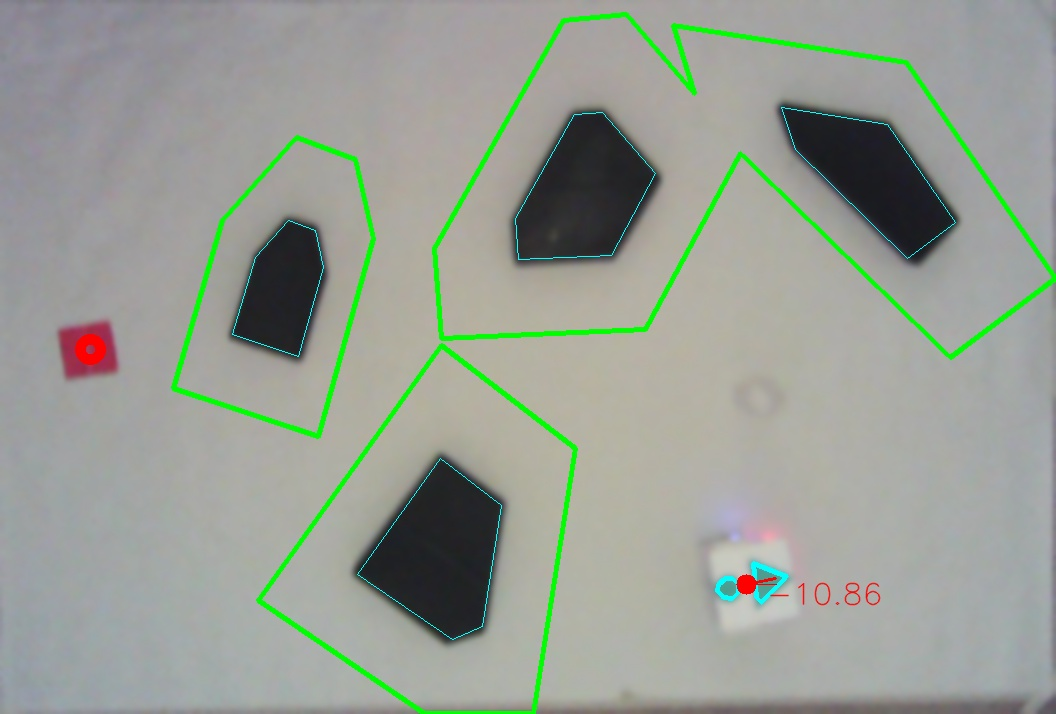

In [10]:
(   area_image,
    (pos0, robot_angle),
    goal,
    obstacles,
    orig_obstacles,
    ) = cvm.get_area_elements()
helpers.display_image_in_notebook(area_image)

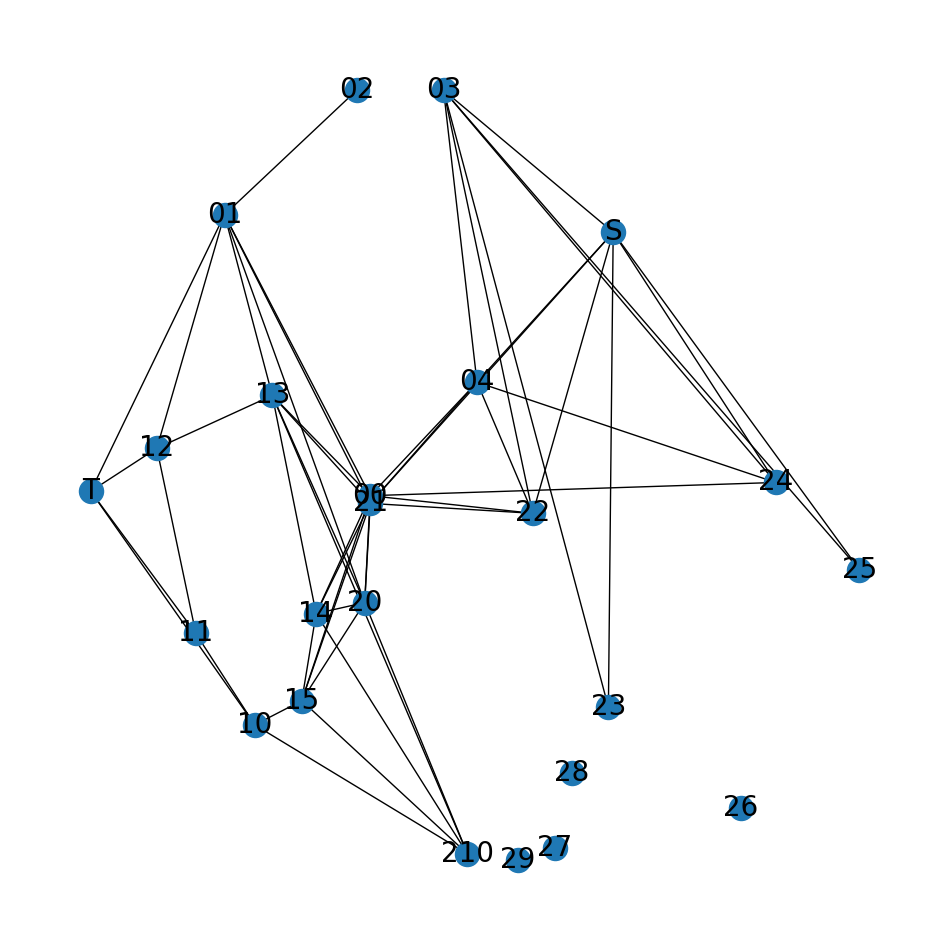

[(575, 448), (441, 345), (318, 436), (173, 388), (90, 349)]


In [11]:
path = gn.find_path(
        pos0,
        obstacles,
        goal,
        (cvm.crop_params[2], cvm.crop_params[3]),
        display_graph=True,
    )
pos = pos0
nextP = path.pop(0)
print(path)

In [12]:
kfm = kf.KalmanFilterManager(robot_angle, pos0, node)

#### Main Loop :

In [13]:
pos = pos0
nextP = path.pop(0)
await node.wait_for_variables()  # wait for the variables to be updated
kfm = kf.KalmanFilterManager(robot_angle, pos0, node)

while (not mc.checkPoint(pos, goal, SECURITYD)) or len(path) != 0:
    # check if there is an obstacle in front of the robot
    if await ln.seeObs(node, OBSTACLE_TRESHOLD):
        await ln.avoidObs(node)
    else:
        if mc.checkPoint(pos, nextP, SECURITYD):
            nextP = path.pop(0)
            currentNode = nextP
        await mc.moveToPoint(node, pos, robot_angle, nextP, SPEED)

    pos, robot_angle = cvm.get_robot_coordinates()
    pos, robot_angle = kfm.update_position((robot_angle, pos))
    cvm.est_coords = (pos, robot_angle)

In [14]:
await node.stop()

In [15]:
cvm.stop()

: 